In [17]:
import datetime
import importlib
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import yfinance as yf
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import misc
importlib.reload(misc)

<module 'misc' from '/Users/K/works/git/jm-xgb/misc.py'>

In [14]:
start_date = "2013-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")

In [15]:
ticker = [
    "XLB", "XLE", "XLF", "XLI", "XLK", "XLP", "XLU", "XLV", "XLY"
] 
df: pd.Series = yf.download(ticker, start=start_date, end=end_date)["Close"]
rets = np.log(df).diff().dropna()

[*********************100%***********************]  9 of 9 completed


In [16]:
rets.shape

(3245, 9)

In [ ]:
def run(rets, start_idx, n_regimes, jump_penalty, freq):
    scaler = misc.Scaler()
    clipper = misc.Clipper(mul=3)
    model = misc.JumpModel(n_regimes=n_regimes, jump_penalty=jump_penalty)
    clf = XGBClassifier()

    last_fit_date = None
    def should_fit(last_fit_date, current_date, freq):
        current = current_date.date()
        if last_fit_date is None:
            return True
        delta = current - last_fit_date
        return delta.days >= freq
    
    n = rets.shape[0]
    current_idx = start_idx
    end_idx = n - 1
    w = np.ones(n)
    while True:
        current_idx += 1
        obs = rets[:current_idx]
        X = misc.feature_engineer(obs)
        if should_fit(last_fit_date, obs.index[-1], freq):
            last_fit_date = obs.index[-1].date()
            X_processed = scaler.fit_transform(clipper.fit_transform(X))
            model.fit(X_processed)
            labels = misc.rearange_labels(model.labels, obs)
            y = pd.Series(labels).shift(-1)
            y_idx = y.dropna().index
            clf.fit(X_processed.loc[y_idx], y.loc[y_idx].astype(int))
        else:
            X_processed = scaler.transform(clipper.transform(X))
            pred_labels, pred_probs = model.prediction(X_processed)
            labels = misc.rearange_labels(pred_labels, obs)

        w[current_idx] = labels[-1]
        if current_idx == end_idx:
            break

    return w

In [ ]:


X = feature_engineer(rets["XLB"])
X

,dd_log_hl5,dd_log_hl21,mean_hl5,mean_hl10,mean_hl21
Date,,,,,
2013-01-03,-4.919523,-4.919523,-0.007303,-0.007303,-0.007303
2013-01-04,-4.988838,-4.936026,-0.004774,-0.005995,-0.006668
2013-01-07,-5.051328,-4.951137,-0.004424,-0.005732,-0.006519
2013-01-08,-5.120643,-4.967640,-0.003651,-0.005244,-0.006257
2013-01-09,-5.189957,-4.984144,-0.002343,-0.004461,-0.005845
...,...,...,...,...,...
2025-11-19,-4.959691,-4.955501,-0.001284,-0.001155,-0.000843
2025-11-20,-4.768532,-4.900825,-0.003065,-0.002085,-0.001304
2025-11-21,-4.837846,-4.917329,0.000197,-0.000463,-0.000543


In [ ]:
X_processed = scaler.fit_transform(clipper.fit_transform(X))




model.fit(X_processed)

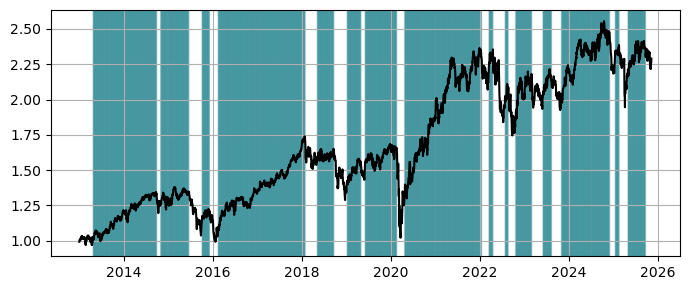

In [187]:
days = X.index

fig, ax = plt.subplots(1, 1, figsize=(7, 3), tight_layout=True)
colors = ["white", "#4597A0", "blue", "orange"]
ax.plot(np.array(days), np.array((1 + raw_data["XLB"]).cumprod()), color="black")
for idx, item in enumerate(model.labels[:-1]):
    start_date = days[idx]
    end_date = days[idx+1]
    ax.axvspan(start_date, end_date, color=colors[item], alpha=0.3)
ax.grid()
plt.show()

In [188]:
feat = pd.concat([X, macro_data], axis=1)
regime = pd.Series(model.labels, index=X.index)

In [189]:
feat

,dd_log_hl5,dd_log_hl21,mean_hl5,mean_hl10,mean_hl21,sortino_hl5,sortino_hl10,sortino_hl21,y2,ewm10,ewm21,ewm63
Date,,,,,,,,,,,,
2013-01-03,-4.919000,-4.919000,-0.007306,-0.007306,-0.007306,-0.999999,-0.999999,-0.999999,0.000000,1.594018,0.060000,-0.008208
2013-01-04,-4.988315,-4.935504,-0.004778,-0.005998,-0.006672,-0.700875,-0.849927,-0.928397,0.000000,1.598437,0.058377,-0.008681
2013-01-07,-5.050797,-4.950612,-0.004428,-0.005736,-0.006523,-0.691402,-0.838750,-0.921439,0.000000,1.601890,0.056157,-0.008618
2013-01-08,-5.120112,-4.967116,-0.003654,-0.005248,-0.006261,-0.611507,-0.794458,-0.899126,-0.000649,1.604442,0.054009,-0.008659
2013-01-09,-5.189427,-4.983619,-0.002347,-0.004465,-0.005848,-0.420906,-0.699747,-0.853856,-0.000953,1.606823,0.052255,-0.008413
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-05,-4.853483,-4.908706,-0.003183,-0.002377,-0.001437,-0.408037,-0.312295,-0.194646,0.001158,0.535198,0.000062,0.000242
2025-11-06,-4.892066,-4.917285,-0.003430,-0.002559,-0.001556,-0.457035,-0.342592,-0.212544,-0.000828,0.535520,0.000060,0.001109
2025-11-07,-4.961381,-4.933788,-0.001458,-0.001597,-0.001122,-0.208243,-0.221354,-0.155830,-0.001450,0.537159,0.000708,0.000858


In [190]:
scaler = misc.Scaler()
clipper = misc.Clipper(mul=3)
feat_processed = pd.DataFrame(
    scaler.fit_transform(clipper.fit_transform(feat)),
    columns = feat.columns,
    index = feat.index
)

In [191]:
from typing import Optional, Dict, Any
from dataclasses import dataclass

@dataclass
class XGBRegimeForecaster:
    feat_df: pd.DataFrame
    regime_labels: pd.Series
    horizon: int = 1
    train_end: Optional[str] = None
    smooth_halflife: Optional[int] = None
    xgb_params: Optional[Dict[str, Any]] = None

    def fit_predict(self):
        y = self.regime_labels.shift(-self.horizon).reindex(self.feat_df.index)
        valid_idx = y.dropna().index
        X = self.feat_df.loc[valid_idx]
        y = y.loc[valid_idx].astype(int)
        
        if self.train_end is not None:
            train_mask = X.index <= pd.to_datetime(self.train_end)
        else:
            split = int(len(X) * 0.8)
            train_mask = pd.Series(False, index=X.index)
            train_mask.iloc[:split] = True

        X_train, y_train = X.loc[train_mask], y.loc[train_mask]
        X_test,  y_test  = X.loc[~train_mask], y.loc[~train_mask]

        params = dict(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.9,
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",
            random_state=42,
            n_jobs=-1,
        )
        if self.xgb_params:
            params.update(self.xgb_params)

        clf = XGBClassifier(**params)
        clf.fit(X_train, y_train)

        proba_test = pd.Series(
            clf.predict_proba(X_test)[:, 1],
            index=X_test.index,
            name="p_bear_next"
        )

        if self.smooth_halflife is not None and self.smooth_halflife > 0:
            proba_smoothed = proba_test.ewm(halflife=self.smooth_halflife, adjust=False).mean()
        else:
            proba_smoothed = proba_test.copy()

        y_pred = (proba_smoothed >= 0.5).astype(int)
        y_pred.name = "y_pred_bear_next"

        # 7) 返却（学習器・テスト期間の実測/確率/予測）
        return {
            "model": clf,
            "X_train": X_train, "y_train": y_train,
            "X_test": X_test,   "y_test": y_test,
            "proba_raw": proba_test,
            "proba_smoothed": proba_smoothed,
            "y_pred": y_pred,
            "feature_importance": pd.Series(clf.feature_importances_, index=X.columns, name="gain")
        }

In [192]:
@dataclass
class LGBMRegimeForecaster:
    feat_df: pd.DataFrame
    regime_labels: pd.Series
    horizon: int = 1
    train_end: Optional[str] = None
    smooth_halflife: Optional[int] = None
    lgbm_params: Optional[Dict[str, Any]] = None

    def fit_predict(self):
        # 1) 教師信号を horizon だけ先にシフト（s_{t+1} を t の特徴で当てる）
        y = self.regime_labels.shift(-self.horizon).reindex(self.feat_df.index)
        valid_idx = y.dropna().index
        X = self.feat_df.loc[valid_idx]
        y = y.loc[valid_idx].astype(int)

        # 2) 時系列スプリット（train_end 指定が無い場合は 8:2）
        if self.train_end is not None:
            train_mask = X.index <= pd.to_datetime(self.train_end)
        else:
            split = int(len(X) * 0.8)
            train_mask = pd.Series(False, index=X.index)
            train_mask.iloc[:split] = True

        X_train, y_train = X.loc[train_mask], y.loc[train_mask]
        X_test,  y_test  = X.loc[~train_mask], y.loc[~train_mask]

        # 3) LightGBM 最小構成（XGBoost版に近い挙動）
        params = dict(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=-1,            # LightGBMはデフォルトで深さ制限なし
            num_leaves=31,           # depth~5 相当
            subsample=0.9,
            colsample_bytree=0.9,
            objective="binary",
            random_state=42,
            n_jobs=-1,
            metric="binary_logloss",
        )
        if self.lgbm_params:
            params.update(self.lgbm_params)

        clf = LGBMClassifier(**params)
        clf.fit(X_train, y_train)

        # 4) 予測（確率）
        proba_test = pd.Series(
            clf.predict_proba(X_test)[:, 1],
            index=X_test.index,
            name="p_bear_next"
        )

        # 5) オプション: 確率の指数平滑
        if self.smooth_halflife is not None and self.smooth_halflife > 0:
            proba_smoothed = proba_test.ewm(halflife=self.smooth_halflife, adjust=False).mean()
        else:
            proba_smoothed = proba_test.copy()

        # 6) 閾値 0.5 でクラス化（>0.5 をベア=1）
        y_pred = (proba_smoothed >= 0.5).astype(int)
        y_pred.name = "y_pred_bear_next"

        # 7) 返却
        # LightGBM の feature_importances_ はデフォルトで "split"（分割回数）
        fi = pd.Series(clf.feature_importances_, index=X.columns, name="importance_split")

        return {
            "model": clf,
            "X_train": X_train, "y_train": y_train,
            "X_test": X_test,   "y_test": y_test,
            "proba_raw": proba_test,
            "proba_smoothed": proba_smoothed,
            "y_pred": y_pred,
            "feature_importance": fi.sort_values(ascending=False),
        }


In [196]:
forecaster_XGB = XGBRegimeForecaster(
    feat_df=feat_processed.iloc[:,:8],
    regime_labels=regime,
    horizon=1,                 # s_{t+1} を予測
    train_end="2017-12-31",    # 時系列で学習期間を区切る（未指定なら8:2）
    smooth_halflife=8,         # 予測確率を少し平滑化（無しなら None）
    xgb_params=None            # 追加/上書きしたい時に辞書を渡す
)

forecaster_LGBM = LGBMRegimeForecaster(
    feat_df=feat_processed.iloc[:,:8],
    regime_labels=regime,
    horizon=1,                 # s_{t+1} を予測
    train_end="2017-12-31",    # 未指定なら 8:2 時系列スプリット
    smooth_halflife=8,         # 予測確率を平滑化（無しなら None）
    lgbm_params=None           # 追加/上書きパラメータを渡せます
)

res_XGB = forecaster_XGB.fit_predict()
res_LGBM = forecaster_LGBM.fit_predict()

In [197]:
res_XGB

{'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.9, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=200,
               n_jobs=-1, num_parallel_tree=None, random_state=42, ...),
 'X_train':             dd_log_hl5  dd_log_hl21  mean_hl5  mean_hl10  mean_hl21  \
 Date                                                                  
 2013-01-03    0.212214    -0.052304 -2.650543  -3.271520  -3.255340  

In [198]:
res_LGBM

{'model': LGBMClassifier(colsample_bytree=0.9, learning_rate=0.05,
                metric='binary_logloss', n_estimators=300, objective='binary',
                random_state=42, subsample=0.9),
 'X_train':             dd_log_hl5  dd_log_hl21  mean_hl5  mean_hl10  mean_hl21  \
 Date                                                                  
 2013-01-03    0.212214    -0.052304 -2.650543  -3.271520  -3.255340   
 2013-01-04    0.067734    -0.098004 -1.768669  -3.186161  -3.255340   
 2013-01-07   -0.062505    -0.139841 -1.646570  -3.052545  -3.255340   
 2013-01-08   -0.206985    -0.185541 -1.376641  -2.804489  -3.255340   
 2013-01-09   -0.351465    -0.231241 -0.920670  -2.406413  -3.255340   
 ...                ...          ...       ...        ...        ...   
 2017-12-22   -1.456189    -2.009356  0.601107   0.613557   0.700140   
 2017-12-26   -1.589411    -2.052245  0.470022   0.533121   0.650199   
 2017-12-27   -1.733891    -2.097945  0.453245   0.531469   0.654525   
 2

In [199]:
print("Test AUC-ish quick check (not exact AUC):",
      np.corrcoef(res_XGB["y_test"], res_XGB["proba_smoothed"])[0,1])
print("Feature importance (gain):")
print(res_XGB["feature_importance"].sort_values(ascending=False).head())

Test AUC-ish quick check (not exact AUC): 0.5759342048136499
Feature importance (gain):
sortino_hl21    0.432226
mean_hl21       0.314786
sortino_hl5     0.049412
mean_hl10       0.049007
dd_log_hl21     0.043366
Name: gain, dtype: float32


In [200]:
print("Test AUC-ish quick check (not exact AUC):",
      np.corrcoef(res_LGBM["y_test"], res_LGBM["proba_smoothed"])[0,1])
print("Feature importance (gain):")
print(res_LGBM["feature_importance"].sort_values(ascending=False).head())

Test AUC-ish quick check (not exact AUC): 0.5677174496236088
Feature importance (gain):
dd_log_hl21     1633
mean_hl21       1529
sortino_hl21    1257
dd_log_hl5      1256
mean_hl5        1010
Name: importance_split, dtype: int32
